In [3]:
import os, re
from string import punctuation
import numpy as np
import json
from collections import Counter
from pprint import pprint
from nltk import sent_tokenize
punctuation += "«»—…“”"
punct = set(punctuation)
from sklearn.metrics import classification_report, accuracy_score
from razdel import sentenize
from razdel import tokenize as razdel_tokenize
import textdistance
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances

In [4]:
!pip install textdistance

In [5]:
bad = open('sents_with_mistakes.txt', encoding='utf8').read().splitlines()
true = open('correct_sents.txt', encoding='utf8').read().splitlines()
corpus = open('wiki_data.txt', encoding='utf8').read()

In [6]:
def get_closest_match_vec(text, X, vec, topn=20):
    v = vec.transform([text])
    
    similarities = cosine_distances(v, X)[0]
    topn = similarities.argsort()[:topn] 
    
    return [(id2word[top], similarities[top]) for top in topn]


def get_closest_match_with_metric(text, lookup, topn=20, metric=textdistance.levenshtein):
    similarities = Counter()
    
    for word in lookup:
        similarities[word] = metric.normalized_similarity(text, word) 
    
    return similarities.most_common(topn)

def get_closest_hybrid_match(text, X, vec, topn=10, metric=textdistance.damerau_levenshtein):
    candidates = get_closest_match_vec(text, X, vec, topn*4)
    lookup = [cand[0] for cand in candidates]
    closest = get_closest_match_with_metric(text, lookup, topn, metric=metric)
    closest_with_freq = [(word, dist, P(text, N)) for word, dist in closest]
    return sorted(closest_with_freq, key=lambda x: (x[1], x[2]), reverse=True)


def P(word, N):
    return vocab[word] / N

def predict_mistaken(word, vocab):
    return 0 if word in vocab else 1

In [7]:
vocab = Counter(re.findall('\w+', corpus.lower()))

word2id = list(vocab.keys())
id2word = {i:word for i, word in enumerate(vocab)}


vec = CountVectorizer(analyzer='char', ngram_range=(1,3), max_features=1000)
X = vec.fit_transform(vocab)
N = sum(vocab.values())

In [8]:
get_closest_hybrid_match('импатичный', X, vec)

[('симпатичный', 0.9090909090909091, 0.0),
 ('симпатичным', 0.8181818181818181, 0.0),
 ('симпатичные', 0.8181818181818181, 0.0),
 ('симпатичных', 0.8181818181818181, 0.0),
 ('симпатичной', 0.8181818181818181, 0.0),
 ('симпатичная', 0.7272727272727273, 0.0),
 ('симпатичнее', 0.7272727272727273, 0.0),
 ('несимпатичных', 0.6923076923076923, 0.0),
 ('симпатичного', 0.6666666666666667, 0.0),
 ('драматичный', 0.6363636363636364, 0.0)]

In [9]:
get_closest_hybrid_match('симптичный', X, vec)

[('симпатичный', 0.9090909090909091, 0.0),
 ('симпатичным', 0.8181818181818181, 0.0),
 ('симпатичных', 0.8181818181818181, 0.0),
 ('симпатичные', 0.8181818181818181, 0.0),
 ('симпатичной', 0.8181818181818181, 0.0),
 ('симметричный', 0.75, 0.0),
 ('симпатичнее', 0.7272727272727273, 0.0),
 ('типичный', 0.7, 0.0),
 ('семичный', 0.7, 0.0),
 ('кирпичный', 0.7, 0.0)]

In [10]:
def align_words(sent_1, sent_2):
    tokens_1 = sent_1.lower().split()
    tokens_2 = sent_2.lower().split()
    
    tokens_1 = [token.strip(punctuation) for token in tokens_1]
    tokens_2 = [token.strip(punctuation) for token in tokens_2]
    
    tokens_1 = [token for token in tokens_1 if token]
    tokens_2 = [token for token in tokens_2 if token]
    
    assert len(tokens_1) == len(tokens_2)
    
    return list(zip(tokens_1, tokens_2))

In [11]:
mistakes = []
total_mistaken = 0
mistaken_fixed = 0

total_correct = 0
correct_broken = 0

total = 0
correct = 0

cashed = {}
for i in range(len(true)):
    word_pairs = align_words(true[i], bad[i])
    for pair in word_pairs:
        if predict_mistaken(pair[1], vocab):
            pred = cashed.get(pair[1], get_closest_hybrid_match(pair[1], X, vec)[0][0])
            cashed[pair[1]] = pred
        else:
            pred = pair[1]
        
            
        if pred == pair[0]:
            correct += 1
        else:
            mistakes.append((pair[0], pair[1], pred))
        total += 1
            
        if pair[0] == pair[1]:
            total_correct += 1
            if pair[0] != pred:
                correct_broken += 1
        else:
            total_mistaken += 1
            if pair[0] == pred:
                mistaken_fixed += 1
    
    if not i % 100:
        print(i)


0
100
200
300
400
500
600
700
800
900


In [12]:
print(correct/total)
print(mistaken_fixed/total_mistaken)
print(correct_broken/total_correct)

0.8536268134067033
0.47282608695652173
0.09004249454461927


Сравним с тем, что было:

0.8527263631815908
0.4658385093167702
0.09004249454461927

Вывод: стало чуть лучше

2 задание

In [25]:
correct_words = list(vocab.keys())

In [26]:
WORDS = [i for i in vocab]

vocab = Counter(re.findall('\w+', corpus.lower()))

word2id = list(vocab.keys())
id2word = {i:word for i, word in enumerate(vocab)}


vec = CountVectorizer(analyzer='char', ngram_range=(1,3), max_features=1000)
X = vec.fit_transform(vocab)
N = sum(vocab.values())

In [27]:
del_vocab = {}

for word in WORDS:
    splits = [(word[:i], word[i:]) for i in range(len(word) + 1)]
    delets = [L + R[1:] for L, R in splits if R]
    for d in set(delets):
        if d in del_vocab:
            del_vocab[d].append(word)
        else:
            del_vocab[d] = [word]

In [28]:
def top_proba(words):
    return max(words, key=P)

def correction(word):
    if word in WORDS:
        return word
    elif word in del_vocab:
        return top_proba(del_vocab[word])
    else:
        splits = [(word[:i], word[i:]) for i in range(len(word) + 1)]
        delets = [L + R[1:] for L, R in splits if R]
        options = []
        for d in set(delets):
            if d in del_vocab:
                options += del_vocab[d]
        if len(options) > 0:
            return top_proba(options)
        else:
            return word

In [47]:
mistakes = []
total_mistaken = 0
mistaken_fixed = 0

total_correct = 0
correct_broken = 0

total = 0
correct = 0

cashed = {}
for i in range(len(true)):
    word_pairs = align_words(true[i], bad[i])
    for pair in word_pairs:
        
        predicted = cashed.get(pair[1], correction(pair[1]))
        cashed[pair[1]] = predicted
        
        if predicted == pair[0]:
            correct += 1
        total += 1
        
        if pair[0] == pair[1]:
            total_correct += 1
            if pair[0] !=  predicted:
                correct_broken += 1
        else:
            total_mistaken += 1
            if pair[0] == predicted:
                mistaken_fixed += 1
        
    if not i % 100:
        print(i)

0
100
200
300
400
500
600
700
800
900


In [48]:
print(correct/total)
print(mistaken_fixed/total_mistaken)
print(correct_broken/total_correct)

0.8726363181590795
0.3423913043478261
0.04892615137245894


# 3 Задание

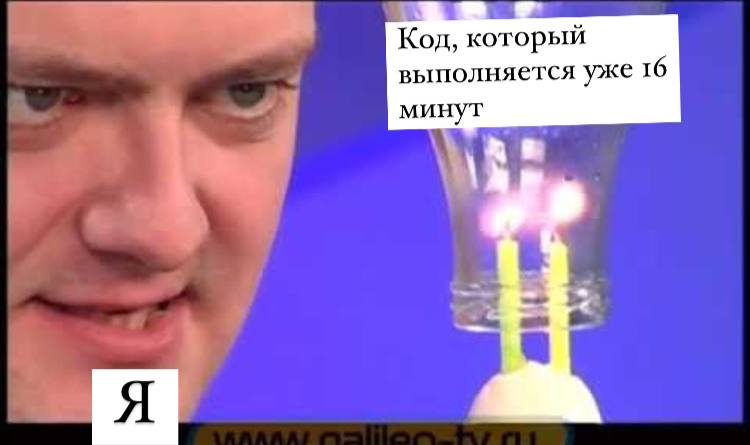

In [35]:
def get_metrics(func, *args, **kwargs):
    mistakes = []
    total_mistaken = 0
    mistaken_fixed = 0

    total_correct = 0
    correct_broken = 0

    total = 0
    correct = 0

    cashed = {}
    for i in range(len(true)):
        word_pairs = align_words(true[i], bad[i])
        for pair in word_pairs:
            if predict_mistaken(pair[1], vocab):
                pred = cashed.get(pair[1], func(pair[1], X, vec, *args, **kwargs)[0][0])
                cashed[pair[1]] = pred
            else:
                pred = pair[1]


            if pred == pair[0]:
                correct += 1
            else:
                mistakes.append((pair[0], pair[1], pred))
            total += 1

            if pair[0] == pair[1]:
                total_correct += 1
                if pair[0] != pred:
                    correct_broken += 1
            else:
                total_mistaken += 1
                if pair[0] == pred:
                    mistaken_fixed += 1

        if not i % 100:
            print(i)
    return correct / total, mistaken_fixed / total_mistaken, correct_broken / total_correct

In [36]:
vocab = Counter(re.findall('\w+', corpus.lower()))

word2id = list(vocab.keys())
id2word = {i:word for i, word in enumerate(vocab)}


vec = CountVectorizer(analyzer='char', ngram_range=(1,3), max_features=1000)
X = vec.fit_transform(vocab)

1) Что там по стандартным параметрам?

In [54]:
res = get_metrics(get_closest_hybrid_match)

0
100
200
300
400
500
600
700
800
900
correct/total: 0.8542271135567784
mistaken_fixed/total_mistaken: 0.47748447204968947
correct_broken/total_correct: 0.09004249454461927


In [65]:
%%time

print(f"correct/total: {(res[0])}")
print(f"mistaken_fixed/total_mistaken: {(res[1])}")
print(f"correct_broken/total_correct: {(res[2])}")

correct/total: 0.8542271135567784
mistaken_fixed/total_mistaken: 0.47748447204968947
correct_broken/total_correct: 0.09004249454461927
CPU times: user 1.09 ms, sys: 1.36 ms, total: 2.45 ms
Wall time: 5.43 ms


2) Попробую поменять макс фичерс!

In [62]:
vec = CountVectorizer(analyzer='char', ngram_range=(1,3), max_features=2000)
X = vec.fit_transform(vocab)

res = get_metrics(get_closest_hybrid_match)

0
100
200
300
400
500
600
700
800
900


In [63]:
%%time

print(f"correct/total: {(res[0])}")
print(f"mistaken_fixed/total_mistaken: {(res[1])}")
print(f"correct_broken/total_correct: {(res[2])}")

correct/total: 0.8542271135567784
mistaken_fixed/total_mistaken: 0.47748447204968947
correct_broken/total_correct: 0.09004249454461927
CPU times: user 307 µs, sys: 151 µs, total: 458 µs
Wall time: 351 µs


3) Ничего не измнилось, а если понизить?

In [46]:
vec = CountVectorizer(analyzer='char', ngram_range=(1,3), max_features=800)
X = vec.fit_transform(vocab)

res = get_metrics(get_closest_hybrid_match)

0
100
200
300
400
500
600
700
800
900


In [47]:
%%time

print(f"correct/total: {(res[0])}")
print(f"mistaken_fixed/total_mistaken: {(res[1])}")
print(f"correct_broken/total_correct: {(res[2])}")

correct/total: 0.8546273136568284
mistaken_fixed/total_mistaken: 0.4805900621118012
correct_broken/total_correct: 0.09004249454461927
CPU times: user 499 µs, sys: 147 µs, total: 646 µs
Wall time: 1.09 ms


4) Результат улучшился, а если сильно повысить?

In [48]:
vec = CountVectorizer(analyzer='char', ngram_range=(1,3), max_features=4000)
X = vec.fit_transform(vocab)

res = get_metrics(get_closest_hybrid_match)


0
100
200
300
400
500
600
700
800
900


In [50]:
%%time

print(f"correct/total: {(res[0])}")
print(f"mistaken_fixed/total_mistaken: {(res[1])}")
print(f"correct_broken/total_correct: {(res[2])}")

correct/total: 0.8548274137068534
mistaken_fixed/total_mistaken: 0.48214285714285715
correct_broken/total_correct: 0.09004249454461927
CPU times: user 2.72 ms, sys: 2.19 ms, total: 4.91 ms
Wall time: 11.3 ms


5) Результат стал лучше, но время увеличилось примерно в 10 раз!

Теперь повышаем н-граммы

In [ ]:
vec = CountVectorizer(analyzer='char', ngram_range=(1,5), max_features=800)
X = vec.fit_transform(vocab)

res = get_metrics(get_closest_hybrid_match)

In [51]:
%%time

print(f"correct/total: {(res[0])}")
print(f"mistaken_fixed/total_mistaken: {(res[1])}")
print(f"correct_broken/total_correct: {(res[2])}")

correct/total: 0.8548274137068534
mistaken_fixed/total_mistaken: 0.48214285714285715
correct_broken/total_correct: 0.09004249454461927
CPU times: user 371 µs, sys: 118 µs, total: 489 µs
Wall time: 420 µs


6) Если повысить н-граммы, результат не меняется, попробую посмотреть на topn

In [ ]:
vec = CountVectorizer(analyzer='char', ngram_range=(1,3), max_features=4000)
X = vec.fit_transform(vocab)

res = get_metrics(get_closest_hybrid_match, topn=50)

In [52]:
%%time

print(f"correct/total: {(res[0])}")
print(f"mistaken_fixed/total_mistaken: {(res[1])}")
print(f"correct_broken/total_correct: {(res[2])}")

correct/total: 0.8548274137068534
mistaken_fixed/total_mistaken: 0.48214285714285715
correct_broken/total_correct: 0.09004249454461927
CPU times: user 471 µs, sys: 135 µs, total: 606 µs
Wall time: 1.02 ms


7) Результат не улучшился, хотя в прошлой версии ДЗ он повысился.

In [53]:
vec = CountVectorizer(analyzer='char', ngram_range=(1,5), max_features=4000)
X = vec.fit_transform(vocab)

res = get_metrics(get_closest_hybrid_match, topn=5)

0
100
200
300
400
500
600
700
800
900


In [54]:
%%time

print(f"correct/total: {(res[0])}")
print(f"mistaken_fixed/total_mistaken: {(res[1])}")
print(f"correct_broken/total_correct: {(res[2])}")

correct/total: 0.8545272636318159
mistaken_fixed/total_mistaken: 0.4798136645962733
correct_broken/total_correct: 0.09004249454461927
CPU times: user 532 µs, sys: 517 µs, total: 1.05 ms
Wall time: 585 µs


In [ ]:
Стало слегка хуже.

8) Посмотрю, что будет при повышенных макс фичерс + пониженных н-граммах:

In [56]:
vec = CountVectorizer(analyzer='char', ngram_range=(1,2), max_features=4000)
X = vec.fit_transform(vocab)

res = get_metrics(get_closest_hybrid_match, topn=25)

0
100
200
300
400
500
600
700
800
900


In [57]:
%%time

print(f"correct/total: {(res[0])}")
print(f"mistaken_fixed/total_mistaken: {(res[1])}")
print(f"correct_broken/total_correct: {(res[2])}")

correct/total: 0.8540270135067534
mistaken_fixed/total_mistaken: 0.47593167701863354
correct_broken/total_correct: 0.09004249454461927
CPU times: user 1.15 ms, sys: 419 µs, total: 1.57 ms
Wall time: 3.18 ms


In [ ]:
Стало хуже, н-грамы больше не трогаю.

9) Посмотрим,что получается с max_df, min_df:

In [58]:
vec = CountVectorizer(analyzer='char', max_features=4000, max_df=0.4, min_df=0.04 )
X = vec.fit_transform(vocab)

res = get_metrics(get_closest_hybrid_match, topn=50)

0
100
200
300
400
500
600
700
800
900


In [59]:
%%time

print(f"correct/total: {(res[0])}")
print(f"mistaken_fixed/total_mistaken: {(res[1])}")
print(f"correct_broken/total_correct: {(res[2])}")

correct/total: 0.8491245622811405
mistaken_fixed/total_mistaken: 0.43788819875776397
correct_broken/total_correct: 0.09004249454461927
CPU times: user 1.71 ms, sys: 1.6 ms, total: 3.3 ms
Wall time: 3.4 ms


10) Стало заметно хуже, попробую уменьшить эти параметры: max_df, min_df

In [60]:
vec = CountVectorizer(analyzer='char', max_features=4000, max_df=0.1, min_df=0.001 )
X = vec.fit_transform(vocab)

res = get_metrics(get_closest_hybrid_match, topn=50)

0
100
200
300
400
500
600
700
800
900


In [64]:
%%time

print(f"correct/total: {(res[0])}")
print(f"mistaken_fixed/total_mistaken: {(res[1])}")
print(f"correct_broken/total_correct: {(res[2])}")

correct/total: 0.8542271135567784
mistaken_fixed/total_mistaken: 0.47748447204968947
correct_broken/total_correct: 0.09004249454461927
CPU times: user 606 µs, sys: 1.04 ms, total: 1.65 ms
Wall time: 2.97 ms


# Выводы: для получения наилучшего результаты max_features можно повысить, topn тоже. Ngram_range дает такие себе результаты, поэтому этот параметр лучше оставить в покое. Можно в разные стороны покрутить max_df, min_df - результат будет меняться.¶

# Насчет max_features хотелось бы добавить, что чем этот параметр выше, тем система тратит больше времени на выполнение когда.